# Project 2

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.special import rel_entr
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm

In [2]:
image_path = "assets/image.jpg"
raw_image = Image.open(image_path)

raw_image.size, raw_image.mode
# raw_image

((7525, 5729), 'RGB')

resized image size: (752, 572)


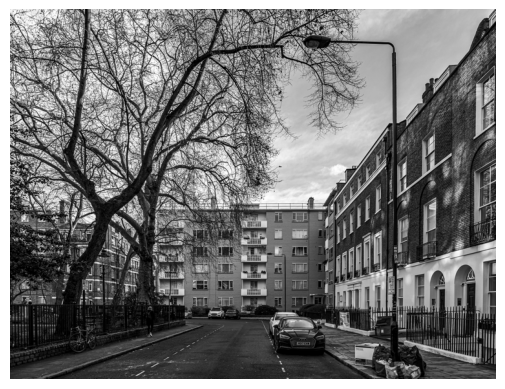

In [3]:
resample_factor = 10

new_width = raw_image.width // resample_factor
new_height = raw_image.height // resample_factor

# Resize image using ANTIALIAS for better quality
resized_image = raw_image.resize((new_width, new_height), Image.LANCZOS)
print("resized image size:", resized_image.size)
image = resized_image.convert("L")
image_array = np.array(image, dtype=np.float32)
image_array /= 255.0 # Normalize to [0, 1]
plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.show()

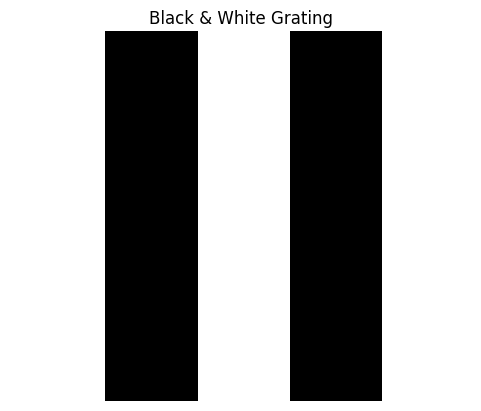

In [4]:
def create_grating(shape=(256, 256), period=50, phase=0, rotation=0):
    height, width = shape
    # Create a coordinate grid
    y, x = np.indices((height, width))
    
    # Convert phase and rotation from degrees to radians
    phase_rad = np.deg2rad(phase)
    theta = np.deg2rad(rotation)
    
    # Rotate the x-coordinates by theta
    x_rot = x * np.cos(theta) + y * np.sin(theta)
    
    # Generate the sinusoidal grating pattern
    grating = np.sin((2 * np.pi / period) * x_rot + phase_rad)
    
    # Convert the sinusoidal pattern to binary
    pattern = (grating >= 0).astype(np.float32)
    return pattern

grating_array = create_grating(shape=(128, 160), period=64, phase=0, rotation=0)

plt.imshow(grating_array, cmap='gray', interpolation='nearest')
plt.title('Black & White Grating')
plt.axis('off')
plt.show()

## Gabor Function

$$
D_s(x, y) = \frac{1}{2\pi\sigma_x\sigma_y} \exp\left( -\frac{x^2}{2\sigma_x^2} - \frac{y^2}{2\sigma_y^2} \right) \cos(kx - \phi).
$$

The parameters in this function determine the properties of the spatial receptive field: 
$\sigma_x$ and $\sigma_y$ determine its extent in the $x$ and $y$ directions, respectively;
$k$, the preferred spatial frequency, determines the spacing of light and dark bars that produce the maximum response 
(the preferred spatial wavelength is $2\pi/k$); and $\phi$ is the preferred spatial phase, which determines 
where the ON-OFF boundaries fall within the receptive field.


(32, 32)

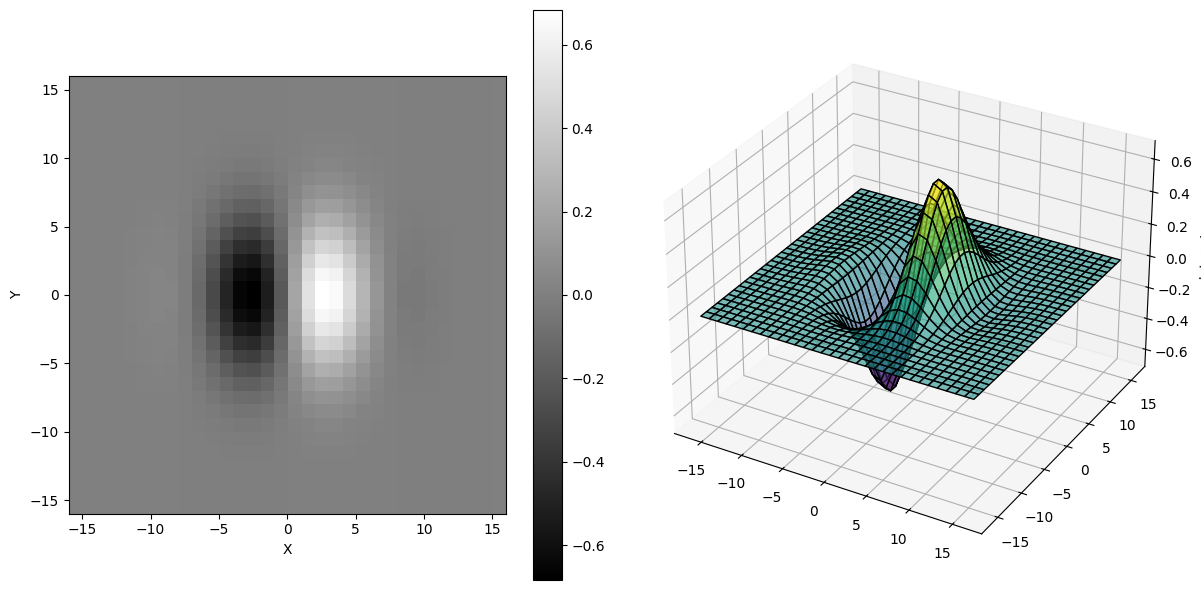

In [5]:
def gabor_function(wavelength, orientation, phase, sigma_x=None, sigma_y=None, axes=None):
    if sigma_x is None:
        sigma_x = wavelength / 4
    if sigma_y is None:
        sigma_y = wavelength / 4
    
    x = np.linspace(-wavelength, wavelength, int(wavelength*2))
    y = np.linspace(-wavelength, wavelength, int(wavelength*2))
    X, Y = np.meshgrid(x, y)
    
    # Rotate coordinates
    x_theta = X * np.cos(orientation) + Y * np.sin(orientation)
    y_theta = -X * np.sin(orientation) + Y * np.cos(orientation)

    # Gabor components
    gaussian_envelope = np.exp(-(x_theta**2 / (2 * sigma_x**2) + y_theta**2 / (2 * sigma_y**2)))
    sinusoid = np.cos(2 * np.pi * x_theta / wavelength + phase)
    gabor = gaussian_envelope * sinusoid
    
    if axes is not None:
        ax2d, ax3d = axes

        # Plot 2D Gabor
        im = ax2d.imshow(gabor, cmap='gray', extent=[-wavelength, wavelength, -wavelength, wavelength])
        ax2d.set_xlabel("X")
        ax2d.set_ylabel("Y")
        ax2d.figure.colorbar(im, ax=ax2d)

        # Plot 3D Gabor
        ax3d.plot_surface(X, Y, gabor, cmap='viridis', edgecolor='k', alpha=0.6)
        ax3d.set_zlabel("Intensity")
        ax3d.set_facecolor('none')
    
    return gabor

# Parameters
neuron_size = 32
wavelength = neuron_size / 2
orientation = np.pi
phase = np.pi / 2
sigma_x = wavelength / 4
sigma_y = wavelength / 4

# Create figure with two subplots side by side
fig = plt.figure(figsize=(12, 6))
ax2d = fig.add_subplot(1, 2, 1)
ax3d = fig.add_subplot(1, 2, 2, projection='3d', elev=30, azim=-60)

gabor = gabor_function(wavelength, orientation, phase, sigma_x, sigma_y, axes=(ax2d, ax3d))
plt.tight_layout()
fig.savefig("figures/gabor.svg", transparent=True, bbox_inches='tight')
gabor.shape


## Estimating Firing Rate

$$
r_{est} = r_0 + F(L(t))
$$

assuming Linear Estimate and a separable temporal factor, we have

$$
F(L(t)) = L_s = \int dxdy \, D(x,y) s(x,y).
$$

where $L_s$ is the spatial linear estimate of the firing rate of a single neuron, $D(x,y)$ is the Gabor function, and $s(x,y)$ is the stimulus.

Neuron center: (64, 49), Response: 0.00
Neuron center: (64, 65), Response: 115.46
Neuron center: (64, 81), Response: -0.00
Neuron center: (64, 97), Response: -115.46


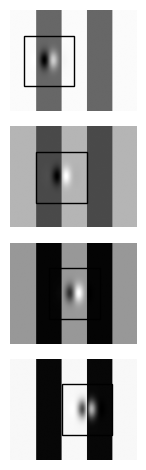

In [6]:
def estimate_single_response(
    image_array: np.ndarray, 
    gabor: np.ndarray, 
    neuron_center: tuple,
    ax: plt.Axes = None,
    ) -> float:
    y_center, x_center = neuron_center

    # Create a zero-padded array of the expected neuron size
    neuron_img_arr = np.zeros((gabor.shape[0], gabor.shape[0]), dtype=image_array.dtype)
    
    # Define the expected boundaries in the image
    y_start_img = max(0, y_center - gabor.shape[0] // 2)
    y_end_img   = min(image_array.shape[0], y_center + gabor.shape[0] // 2)
    x_start_img = max(0, x_center - gabor.shape[1] // 2)
    x_end_img   = min(image_array.shape[1], x_center + gabor.shape[1] // 2)
    
    # Calculate the corresponding indices in the zero-padded neuron image
    offset_y = y_start_img - (y_center - gabor.shape[0] // 2)
    offset_x = x_start_img - (x_center - gabor.shape[1] // 2)
    
    neuron_img_arr[offset_y:offset_y + (y_end_img - y_start_img),
                   offset_x:offset_x + (x_end_img - x_start_img)] = image_array[y_start_img:y_end_img,
                                                                               x_start_img:x_end_img]
    r_est = np.sum(gabor * neuron_img_arr)
    
    if ax is not None:
        # Create an overlay on the full image
        overlay = np.zeros_like(image_array)
        # Only update the region that overlaps with the image
        overlay[y_start_img:y_end_img, x_start_img:x_end_img] = gabor[offset_y:offset_y+(y_end_img - y_start_img),
                                                                      offset_x:offset_x+(x_end_img - x_start_img)]
        alpha = 0.5  # (0 = only image, 1 = only Gabor)
        overlayed_image = (1 - alpha) * image_array + alpha * overlay
        
        ax.imshow(overlayed_image, cmap="gray")
        ax.axis("off")

        # Draw a rectangle around the overlayed region
        rect = patches.Rectangle(
            (x_start_img, y_start_img),  # (x, y) bottom-left corner
            x_end_img - x_start_img,     # width
            y_end_img - y_start_img,     # height
            linewidth=1,
            edgecolor='k',
            facecolor='none'
        )
        ax.add_patch(rect)
    return r_est

# wavelengths = [16, 32, 64]
# shifts = np.arange(16*3, 112, 16)
# fig, axes = plt.subplots(len(shifts), len(wavelengths), figsize=(16, 16))

# for i, wavelength in enumerate(wavelengths):
#     gabor_grating = gabor_function(wavelength=wavelength, orientation=np.pi, phase=np.pi / 2)   

#     for j, shift in enumerate(shifts):
#         neuron_center = (grating_array.shape[0] // 2, int(shift)+1)
#         r_est = estimate_single_response(grating_array, gabor_grating, neuron_center, ax=axes[j, i])
#         print(f"Neuron center: ({neuron_center[0]}, {neuron_center[1]}), Response: {r_est:.2f}")
#         # axes[j, i].set_title(f"Response: {r_est:.2f}")

shifts = np.arange(16*3, 112, 16)
fig, axes = plt.subplots(len(shifts), 1)
gabor_grating = gabor_function(wavelength=32, orientation=np.pi, phase=np.pi / 2)   

for i, shift in enumerate(shifts):
    neuron_center = (grating_array.shape[0] // 2, int(shift)+1)
    r_est = estimate_single_response(grating_array, gabor_grating, neuron_center, ax=axes[i])
    print(f"Neuron center: ({neuron_center[0]}, {neuron_center[1]}), Response: {r_est:.2f}")
    # axes[j, i].set_title(f"Response: {r_est:.2f}")

fig.tight_layout()
fig.savefig("figures/grating_gabor_overlays.svg", transparent=True, bbox_inches='tight', dpi=1200)

In [7]:
# fig, ax = plt.subplots(figsize=(8, 8))
# gabor_grating = gabor_function(wavelength=64, orientation=np.pi, phase=np.pi / 2)   
# neuron_center = (grating_array.shape[0] // 2, 81)
# r_est = estimate_single_response(grating_array, gabor_grating, neuron_center, ax=ax)
# print(f"Neuron center: ({neuron_center[0]}, {neuron_center[1]}), Response: {r_est:.2f}")

# fig.tight_layout()
# fig.savefig("figures/grating_large_gabor_overlay.svg", transparent=True, bbox_inches='tight', dpi=1200)

(np.float64(-1.7453338922348038), (32, 32))

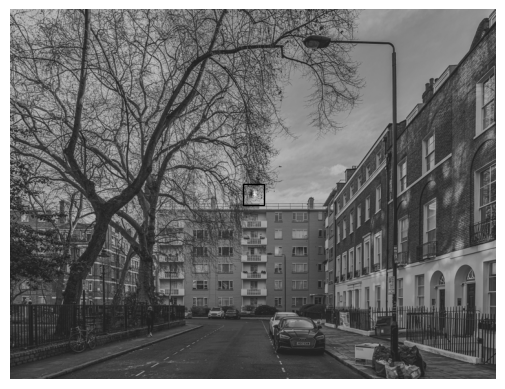

In [8]:
neuron_center = (image_array.shape[0] // 2, image_array.shape[1] // 2)
fig, ax = plt.subplots()
r_est = estimate_single_response(image_array, gabor, neuron_center, ax=ax)
fig.savefig("figures/image_gabor_overlay.svg", transparent=True, bbox_inches='tight')
r_est, gabor.shape

## Encoding

In [9]:
# image_array = create_grating(shape=(128, 160), period=64, phase=0, rotation=0)


number of vertical neurons: 286, number of horizontal neurons: 376
encoded response shape: (268, 358)


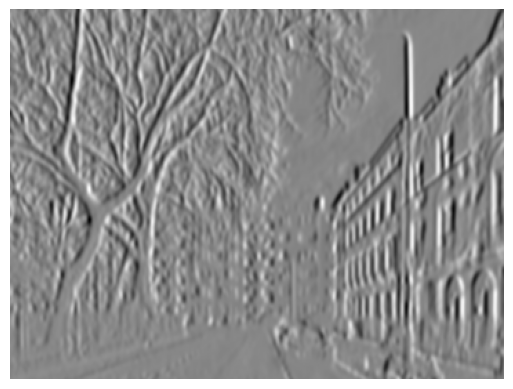

In [10]:
def encode(
    image_array: np.ndarray, 
    gabor: np.ndarray, 
    num_neurons: tuple[int, int],
    ax: plt.Axes = None,
    ) -> np.ndarray:

    n, m = num_neurons
    r_est_array = np.ones((n, m), dtype=np.float32)
    for i in range(n):
        for j in range(m):
            x_center = image_array.shape[0] // n * i
            y_center = image_array.shape[1] // m * j
            neuron_center = (x_center, y_center)
            r_est_array[i, j] = estimate_single_response(
                image_array, gabor, neuron_center)
    
    n_neurons_edge = int((gabor.shape[0] // (image_array.shape[0] / n)) // 2 + 1)
    m_neurons_edge = int((gabor.shape[1] // (image_array.shape[1] / m)) // 2 + 1)
    r_est_array_cropped = r_est_array[n_neurons_edge:-n_neurons_edge, m_neurons_edge:-m_neurons_edge]

    r_est_array_norm = 2 * (r_est_array_cropped - np.min(r_est_array_cropped)) / (np.max(r_est_array_cropped) - np.min(r_est_array_cropped)) - 1
    
    if ax is not None:
        ax.imshow(r_est_array_norm, cmap="gray")
        ax.axis("off")
    return r_est_array_norm

n = image_array.shape[0] // 2
m = image_array.shape[1] // 2
print(f"number of vertical neurons: {n}, number of horizontal neurons: {m}")
fig, ax = plt.subplots()
r_est_array = encode(image_array, gabor, (n, m), ax=ax)
print(f"encoded response shape: {r_est_array.shape}")

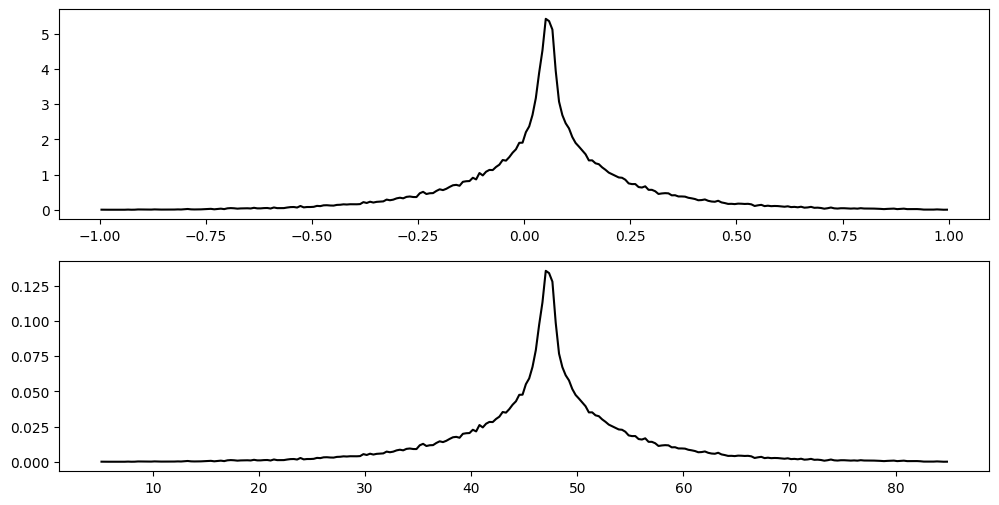

In [11]:
def line_hist(a: np.ndarray, bins: int = 256, ax = None) -> tuple:
    hist, bin_edges = np.histogram(a.flatten(), bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    if ax is not None:
        ax.plot(bin_centers, hist, color='black')
    return hist, bin_centers

def scale_r_est(r_est_array: np.ndarray) -> np.ndarray:
    # Scale the r_est_array to the range [-35, 35]
    r_est_array_scaled = (r_est_array + 2) * 40 - 35
    return r_est_array_scaled

r_est_array_scaled = scale_r_est(r_est_array)
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
r_est_array_hist, r_est_array_bin_centers = line_hist(r_est_array, bins=256, ax=axes[0])
r_est_array_scaled_hist, r_est_array_scaled_bin_centers = line_hist(r_est_array_scaled, bins=256, ax=axes[1])
fig.savefig("figures/r_est_histograms.svg", transparent=True, bbox_inches='tight')

Generating spikes:   0%|          | 0/268 [00:00<?, ?it/s]

Generating spikes:   0%|          | 0/268 [00:00<?, ?it/s]

Generating spikes:   0%|          | 0/268 [00:00<?, ?it/s]

Generating spikes:   0%|          | 0/268 [00:00<?, ?it/s]

268 358


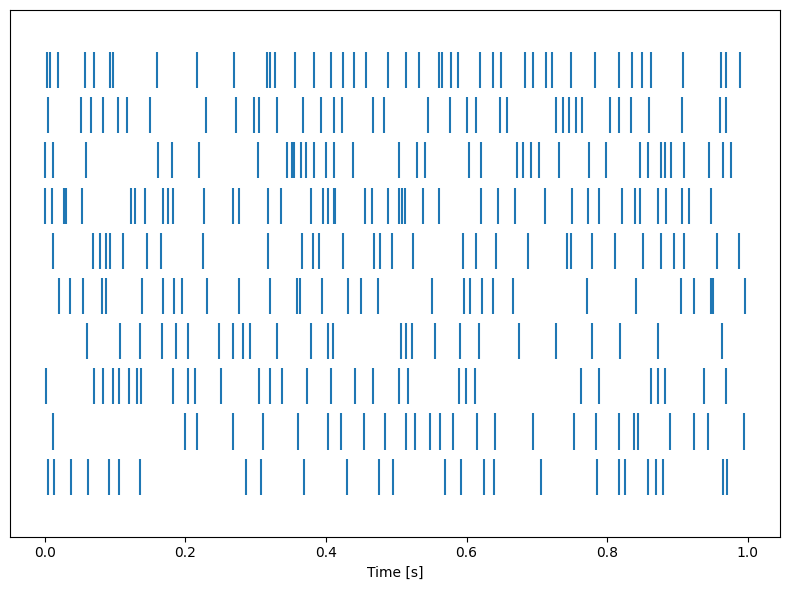

In [12]:
def homogeneous_spike_generator(
    r: float,
    T: float = 1,
    abs_ref: float = 0.001,
    rel_ref_mean: float = 0.01,
    rng: np.random.Generator = np.random.default_rng(),
) -> np.ndarray:
    interspike_intervals = rng.exponential(scale=1/r, size=int(r * T * 2))
    spike_times = np.cumsum(interspike_intervals)
    spike_times = spike_times[spike_times < T]

    valid_spike_times = []
    i = 0
    while i < len(spike_times):
        current_time = spike_times[i]
        valid_spike_times.append(current_time)

        ref_period = abs_ref + rng.exponential(scale=rel_ref_mean)
        i += 1
        while i < len(spike_times) and spike_times[i] < current_time + ref_period:
            i += 1

    return np.array(valid_spike_times)

def model_response_spikes(
    r_est_array: np.ndarray,
    T: float = 1,
    abs_ref: float = 0.001,
    rel_ref_mean: float = 0.01,
    rng: np.random.Generator = np.random.default_rng(),
) -> list[list[np.ndarray]]:
    r_est_array_scaled = scale_r_est(r_est_array)
    population_spikes = []
    for row in tqdm(r_est_array_scaled, desc="Generating spikes"):
        response_row = []
        for r in row:
            spikes = homogeneous_spike_generator(r, T=T, abs_ref=abs_ref, rel_ref_mean=rel_ref_mean, rng=rng)
            response_row.append(spikes)
        population_spikes.append(response_row)
    return population_spikes

rng = np.random.default_rng()

population_spikes = model_response_spikes(r_est_array, T=1, abs_ref=0.001, rel_ref_mean=0.01, rng=rng)
population_spikes_no_ref = model_response_spikes(r_est_array, T=1, abs_ref=0.0, rel_ref_mean=0.0, rng=rng)
population_spikes_long = model_response_spikes(r_est_array, T=10, abs_ref=0.001, rel_ref_mean=0.01, rng=rng)
population_spikes_long_no_ref = model_response_spikes(r_est_array, T=10, abs_ref=0.0, rel_ref_mean=0.0, rng=rng)

n_rows = len(population_spikes)
n_cols = len(population_spikes[0])
print(n_rows, n_cols)

# Plotting the spike trains for the first 10 neurons in the center column
center_col_idx = n_cols // 2
center_column_spikes = [population_spikes[i][center_col_idx] for i in range(n_rows)]
fig, ax = plt.subplots(figsize=(8, 6))
ax.eventplot([spikes[spikes <= 1.0] for spikes in center_column_spikes[:10]], orientation='horizontal', linelengths=0.8)
ax.set_xlabel("Time [s]")
ax.get_yaxis().set_visible(False)
plt.tight_layout()
# plt.savefig("figures/population_spike_trains.svg", transparent=True, bbox_inches='tight')

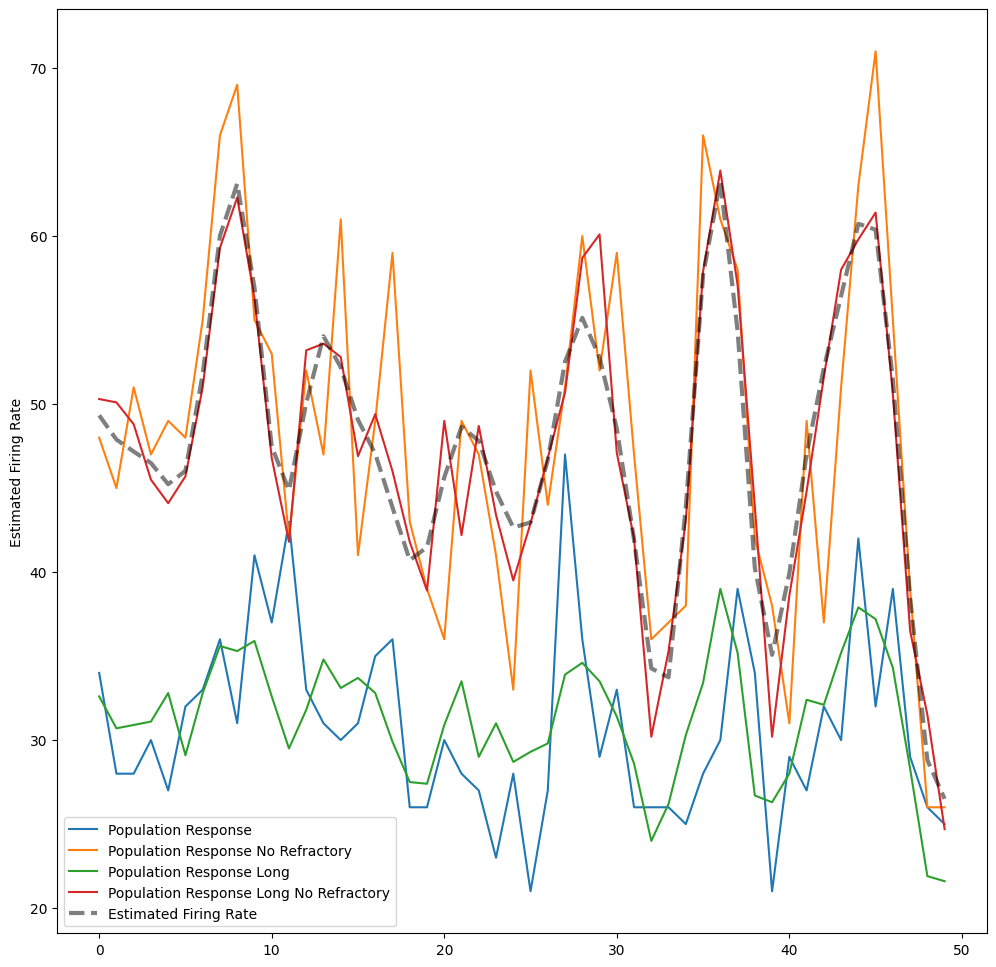

In [13]:
def compute_population_response(population_spikes, T):
    n_rows = len(population_spikes)
    n_cols = len(population_spikes[0])
    
    population_spike_counts = np.zeros((n_rows, n_cols), dtype=int)
    
    for i in range(n_rows):
        for j in range(n_cols):
            population_spike_counts[i, j] = len(population_spikes[i][j])
    
    return population_spike_counts / T

population_response = compute_population_response(population_spikes, T=1)
population_response_no_ref = compute_population_response(population_spikes_no_ref, T=1)
population_response_long = compute_population_response(population_spikes_long, T=10)
population_response_long_no_ref = compute_population_response(population_spikes_long_no_ref, T=10)

center_col_idx = population_response.shape[1] // 2
plt.figure(figsize=(12, 12))
plt.plot(population_response[center_col_idx, :50], label='Population Response', ls='-')
plt.plot(population_response_no_ref[center_col_idx, :50], label='Population Response No Refractory', ls='-')
plt.plot(population_response_long[center_col_idx, :50], label='Population Response Long', ls='-')
plt.plot(population_response_long_no_ref[center_col_idx, :50], label='Population Response Long No Refractory', ls='-')
plt.plot(r_est_array_scaled[center_col_idx, :50], label='Estimated Firing Rate', ls='--', lw=3, c='k', alpha=0.5)
plt.legend()
plt.ylabel("Estimated Firing Rate")
plt.savefig("figures/population_responses_1D.svg", transparent=True, bbox_inches='tight')

In [14]:
# def _scale_r_est(r_est_array: np.ndarray) -> np.ndarray:
#     r_est_array_scaled = (r_est_array + 2) * 120 - 115
#     return r_est_array_scaled

# def _model_response_spikes(
#     r_est_array: np.ndarray,
#     T: float = 1,
#     abs_ref: float = 0.001,
#     rel_ref_mean: float = 0.01,
#     rng: np.random.Generator = np.random.default_rng(),
# ) -> list[list[np.ndarray]]:
#     r_est_array_scaled = _scale_r_est(r_est_array)
#     population_spikes = []
#     for row in tqdm(r_est_array_scaled, desc="Generating spikes"):
#         response_row = []
#         for r in row:
#             spikes = homogeneous_spike_generator(r, T=T, abs_ref=abs_ref, rel_ref_mean=rel_ref_mean, rng=rng)
#             response_row.append(spikes)
#         population_spikes.append(response_row)
#     return population_spikes

# population_spikes = _model_response_spikes(r_est_array, T=1, abs_ref=0.001, rel_ref_mean=0.01, rng=rng)
# population_spikes_no_ref = _model_response_spikes(r_est_array, T=1, abs_ref=0.0, rel_ref_mean=0.0, rng=rng)
# population_spikes_long = _model_response_spikes(r_est_array, T=10, abs_ref=0.001, rel_ref_mean=0.01, rng=rng)
# population_spikes_long_no_ref = _model_response_spikes(r_est_array, T=10, abs_ref=0.0, rel_ref_mean=0.0, rng=rng)

# n_rows = len(population_spikes)
# n_cols = len(population_spikes[0])

# population_response = compute_population_response(population_spikes, T=1)
# population_response_no_ref = compute_population_response(population_spikes_no_ref, T=1)
# population_response_long = compute_population_response(population_spikes_long, T=10)
# population_response_long_no_ref = compute_population_response(population_spikes_long_no_ref, T=10)

# center_col_idx = population_response.shape[1] // 2
# plt.figure(figsize=(12, 12))
# plt.plot(population_response[center_col_idx, :50], label='spike_counts_array', ls='-')
# plt.plot(population_response_no_ref[center_col_idx, :50], label='spike_counts_array_no_ref', ls='-')
# plt.plot(population_response_long[center_col_idx, :50], label='spike_counts_array_long', ls='-')
# plt.plot(population_response_long_no_ref[center_col_idx, :50], label='spike_counts_array_long_no_ref', ls='-')
# plt.plot(_scale_r_est(r_est_array)[center_col_idx, :50], label='r_est_array_scaled', ls='--', lw=3, c='k', alpha=0.5)
# plt.legend()
# plt.savefig("figures/population_responses_1D.svg", transparent=True, bbox_inches='tight')

## Decoding

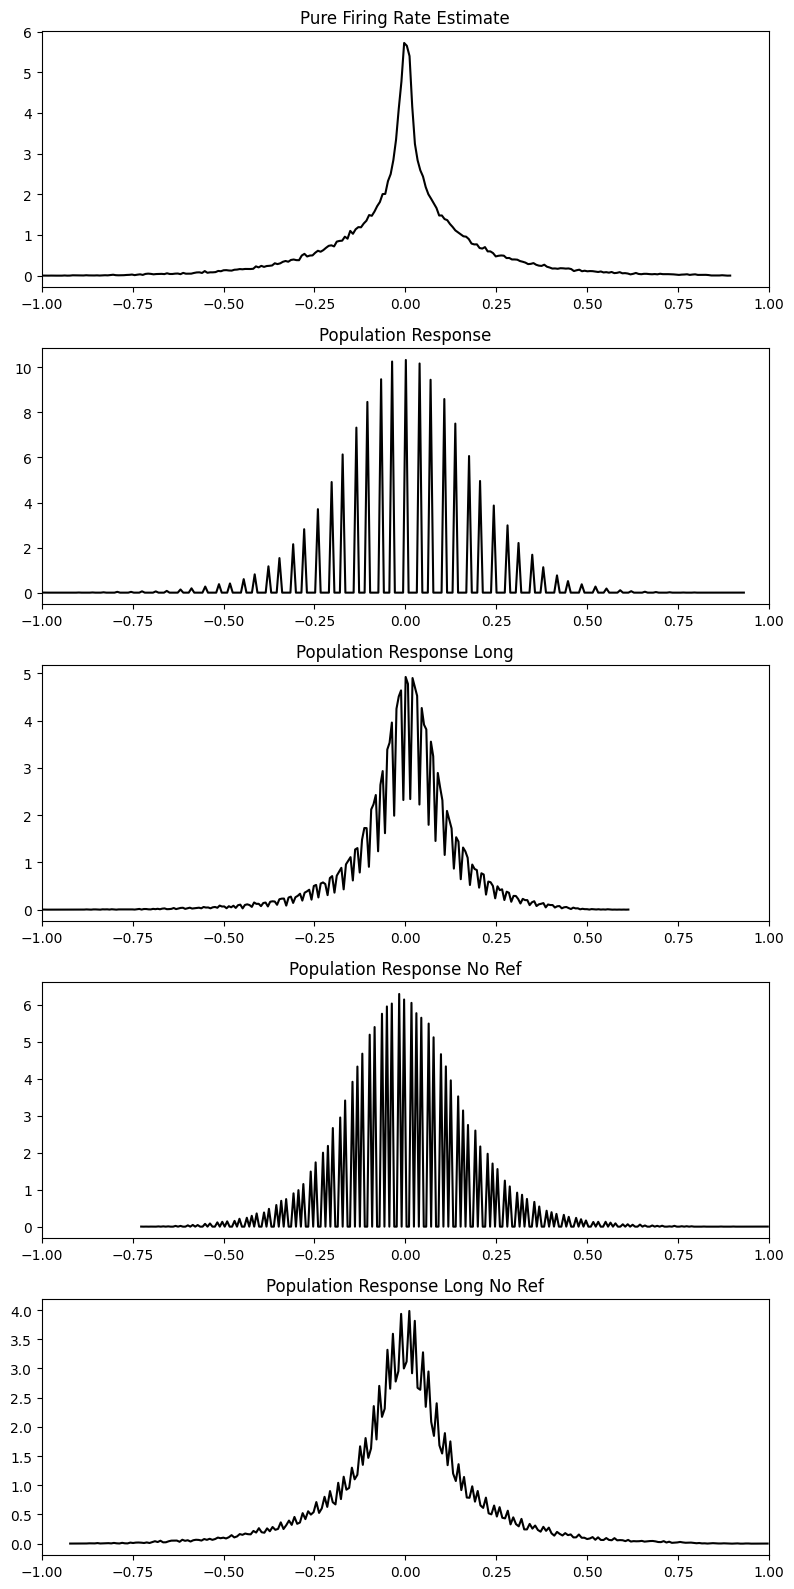

In [15]:
def scale_array(arr):
    arr = np.asarray(arr)
    arr_mean = np.mean(arr)
    arr = arr - arr_mean  # Center around 0 (mean = 0)
    
    max_abs = np.max(np.abs(arr))
    if max_abs == 0:
        return arr  # Avoid division by zero; all values are the same
    return arr / max_abs  # Scale to range [-1, 1]

def decode(
    neural_resp_arr: np.ndarray,
    ) -> np.ndarray:
    scaled_neural_resp_arr = scale_array(neural_resp_arr)
    decoded = np.cumsum(scaled_neural_resp_arr, axis=1)
    return decoded

decoded_r_est_array = decode(r_est_array)
decoded_population_response = decode(population_response)
decoded_population_response_long = decode(population_response_long)
decoded_population_response_no_ref = decode(population_response_no_ref)
decoded_population_response_long_no_ref = decode(population_response_long_no_ref)

fig, axes = plt.subplots(5, 1, figsize=(8, 16))
_, _ = line_hist(scale_array(r_est_array), bins=256, ax=axes[0])
axes[0].set_xlim(-1, 1)
axes[0].set_title("Pure Firing Rate Estimate")
_, _ = line_hist(scale_array(population_response), bins=256, ax=axes[1])
axes[1].set_xlim(-1, 1)
axes[1].set_title("Population Response")
_, _ = line_hist(scale_array(population_response_long), bins=256, ax=axes[2])
axes[2].set_xlim(-1, 1)
axes[2].set_title("Population Response Long")
_, _ = line_hist(scale_array(population_response_no_ref), bins=256, ax=axes[3])
axes[3].set_xlim(-1, 1)
axes[3].set_title("Population Response No Ref")
_, _ = line_hist(scale_array(population_response_long_no_ref), bins=256, ax=axes[4])
axes[4].set_xlim(-1, 1)
axes[4].set_title("Population Response Long No Ref")
fig.tight_layout()
fig.savefig("figures/population_responses_histograms.svg", transparent=True, bbox_inches='tight')

discrete appearance of scaled population response for short time period encoding, because the variation between spike counts is small (integers)

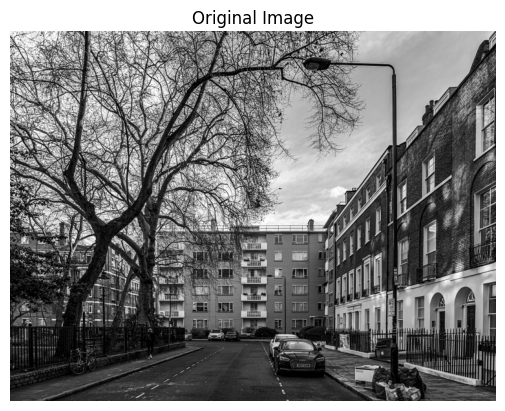

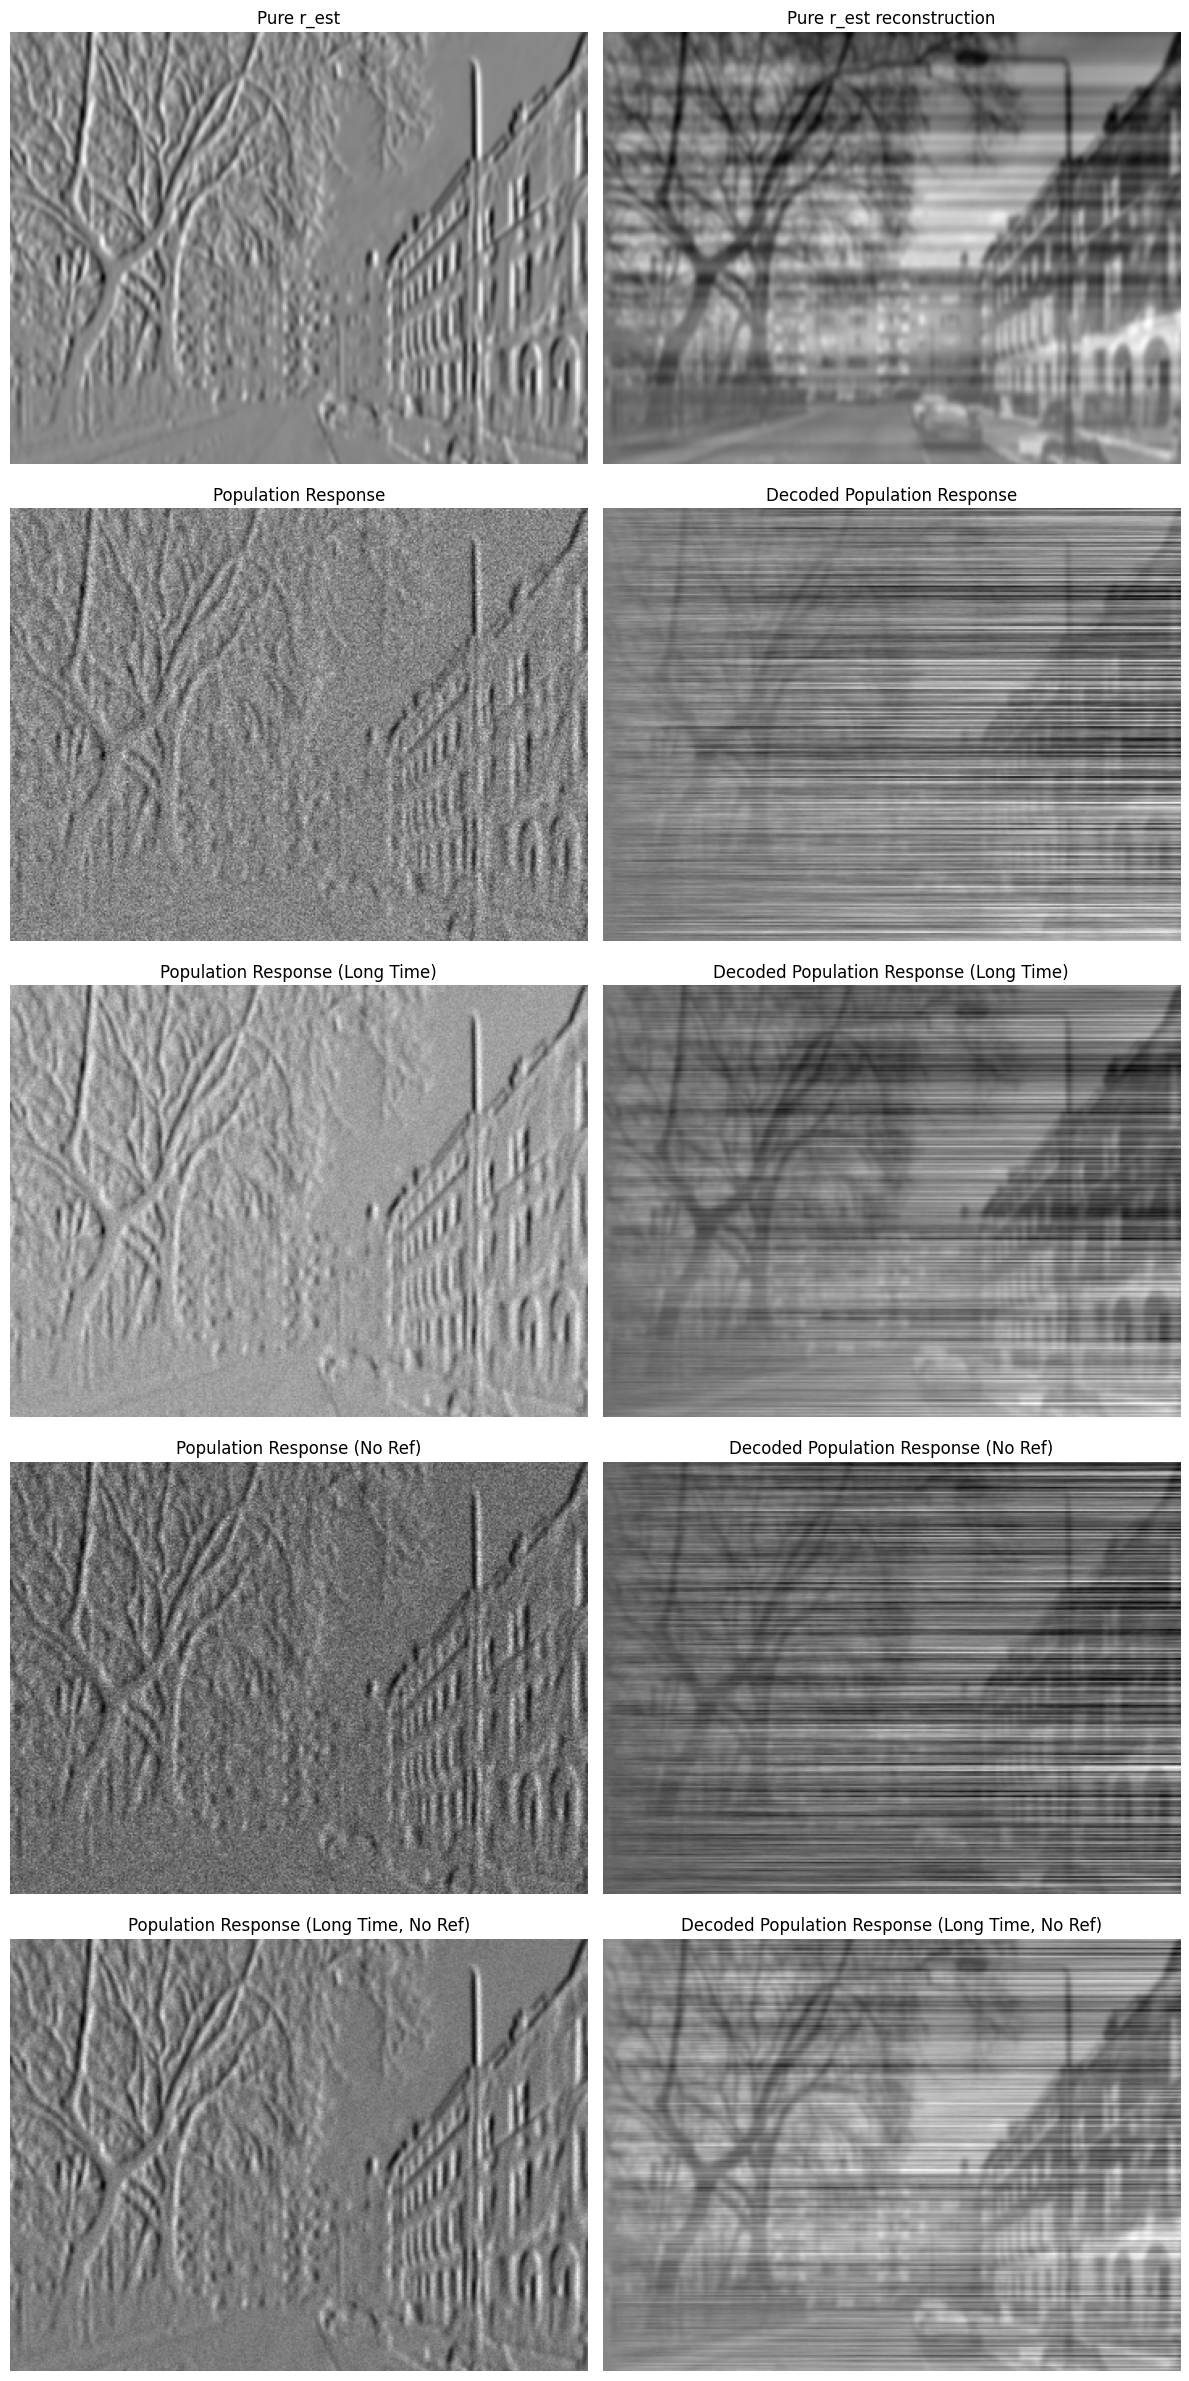

In [16]:
# Plot the images for comparison
plt.figure()
plt.title("Original Image")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.figure(figsize=(12, 24))
plt.subplot(5, 2, 1)
plt.title("Pure r_est")
plt.imshow(r_est_array, cmap='gray')
plt.axis('off')
plt.subplot(5, 2, 2)
plt.title("Pure r_est reconstruction")
plt.imshow(decoded_r_est_array, cmap='gray')
plt.axis('off')

plt.subplot(5, 2, 3)
plt.title("Population Response")
plt.imshow(population_response, cmap='gray')
plt.axis('off')
plt.subplot(5, 2, 4)
plt.title("Decoded Population Response")
plt.imshow(decoded_population_response, cmap='gray')
plt.axis('off')

plt.subplot(5, 2, 5)
plt.title("Population Response (Long Time)")
plt.imshow(population_response_long, cmap='gray')
plt.axis('off')
plt.subplot(5, 2, 6)
plt.title("Decoded Population Response (Long Time)")
plt.imshow(decoded_population_response_long, cmap='gray')
plt.axis('off')

plt.subplot(5, 2, 7)
plt.title("Population Response (No Ref)")
plt.imshow(population_response_no_ref, cmap='gray')
plt.axis('off')
plt.subplot(5, 2, 8)
plt.title("Decoded Population Response (No Ref)")
plt.imshow(decoded_population_response_no_ref, cmap='gray')
plt.axis('off')

plt.subplot(5, 2, 9)
plt.title("Population Response (Long Time, No Ref)")
plt.imshow(population_response_long_no_ref, cmap='gray')
plt.axis('off')
plt.subplot(5, 2, 10)
plt.title("Decoded Population Response (Long Time, No Ref)")
plt.imshow(decoded_population_response_long_no_ref, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.savefig("figures/decoded_population_responses.svg", transparent=True, bbox_inches='tight')

## Multiple Populations

Generating spikes:   0%|          | 0/106 [00:00<?, ?it/s]

Generating spikes:   0%|          | 0/106 [00:00<?, ?it/s]

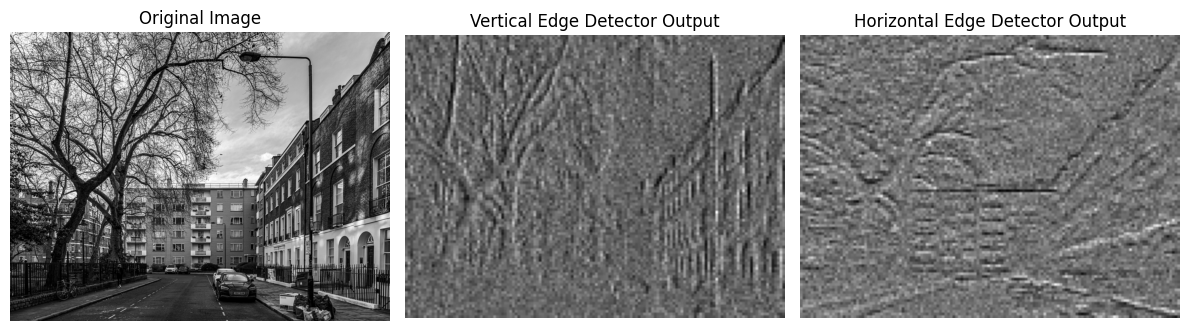

In [17]:
neuron_size = 32
wavelength = neuron_size / 2
phase = np.pi / 2
sigma_x = wavelength/4 # arbitrary choice
sigma_y = wavelength/4 # arbitrary choice

# Define Gabor filters for vertical and horizontal edge detection
vertical_orientation = np.pi           # Vertical edge detector (sensitive to vertical edges)
horizontal_orientation = -np.pi / 2   # Horizontal edge detector (sensitive to horizontal edges)

n = image_array.shape[0] // 5
m = image_array.shape[1] // 5

# Create two Gabor filters with different orientations
gabor_vertical = gabor_function(wavelength, vertical_orientation, phase, sigma_x, sigma_y)
gabor_horizontal = gabor_function(wavelength, horizontal_orientation, phase, sigma_x, sigma_y)

# Encode the image using each filter
r_est_array_vertical = encode(image_array, gabor_vertical, (n, m))
r_est_array_horizontal = encode(image_array, gabor_horizontal, (n, m))

# Generate spike trains
population_spikes_vertical = model_response_spikes(r_est_array_vertical, T=1, abs_ref=0, rel_ref_mean=0, rng=rng)
population_spikes_horizontal = model_response_spikes(r_est_array_horizontal, T=1, abs_ref=0, rel_ref_mean=0, rng=rng)

# Compute population responses
population_response_norm_vertical = compute_population_response(population_spikes_vertical, T=1)
population_response_norm_horizontal = compute_population_response(population_spikes_horizontal, T=1)

# population_response_norm_vertical = r_est_array_vertical
# population_response_norm_horizontal = r_est_array_horizontal

# Plot the images for comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Vertical Edge Detector Output")
plt.imshow(population_response_norm_vertical, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Horizontal Edge Detector Output")
plt.imshow(population_response_norm_horizontal, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

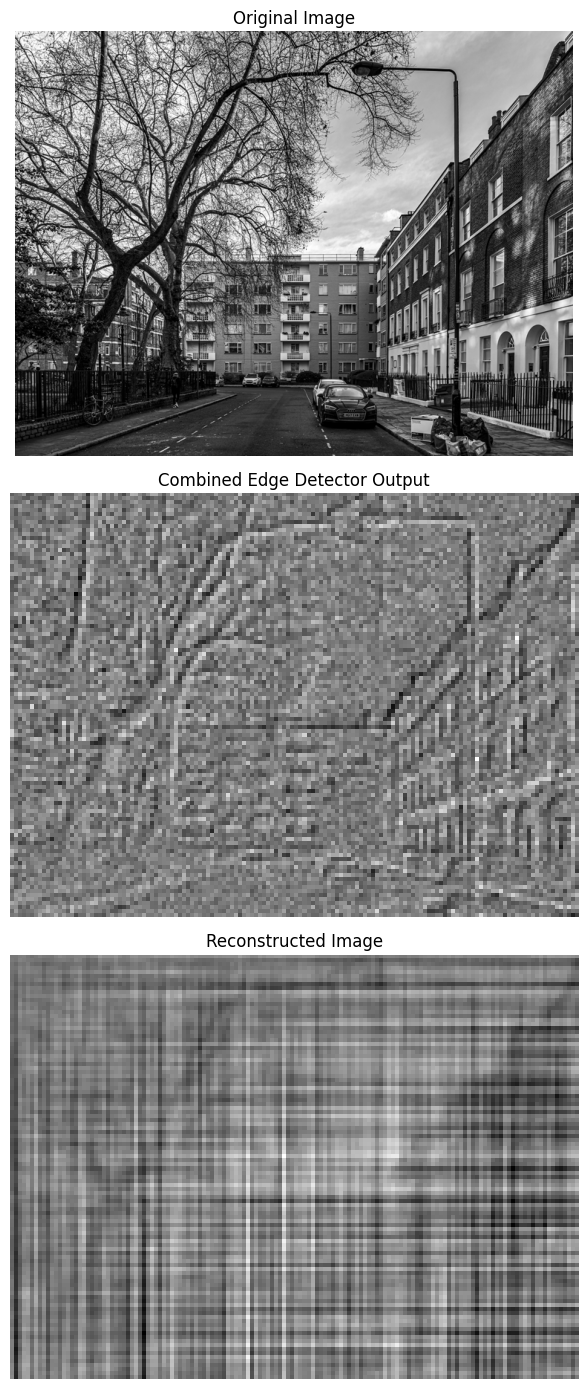

In [18]:
def decode_vh(population_response_vertical: np.ndarray, population_response_horizontal: np.ndarray) -> np.ndarray:
    population_response_vertical_scaled = scale_array(population_response_vertical)
    population_response_horizontal_scaled = scale_array(population_response_horizontal)
    
    # Integrate the vertical edge responses along the horizontal direction (axis=1)
    # This approximates reconstructing the image by integrating the horizontal gradient.
    recon_from_vertical = np.cumsum(population_response_vertical_scaled, axis=1)
    
    # Integrate the horizontal edge responses along the vertical direction (axis=0)
    # This approximates reconstructing the image by integrating the vertical gradient.
    recon_from_horizontal = np.cumsum(population_response_horizontal_scaled, axis=0)
    
    # Combine the two integrated images.
    # A simple approach is to average them, though other weighted combinations might be considered.
    reconstructed = (recon_from_vertical + recon_from_horizontal) / 2
    
    return reconstructed

decoded_population_response = decode_vh(population_response_norm_vertical, population_response_norm_horizontal)

plt.figure(figsize=(6, 14))
plt.subplot(3, 1, 1)
plt.title("Original Image")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(3, 1, 2)
plt.title("Combined Edge Detector Output")
# For visualization
combined_response = (population_response_norm_vertical + population_response_norm_horizontal) / 2
plt.imshow(combined_response, cmap='gray')
plt.axis('off')

plt.subplot(3, 1, 3)
plt.title("Reconstructed Image")
plt.imshow(decoded_population_response, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


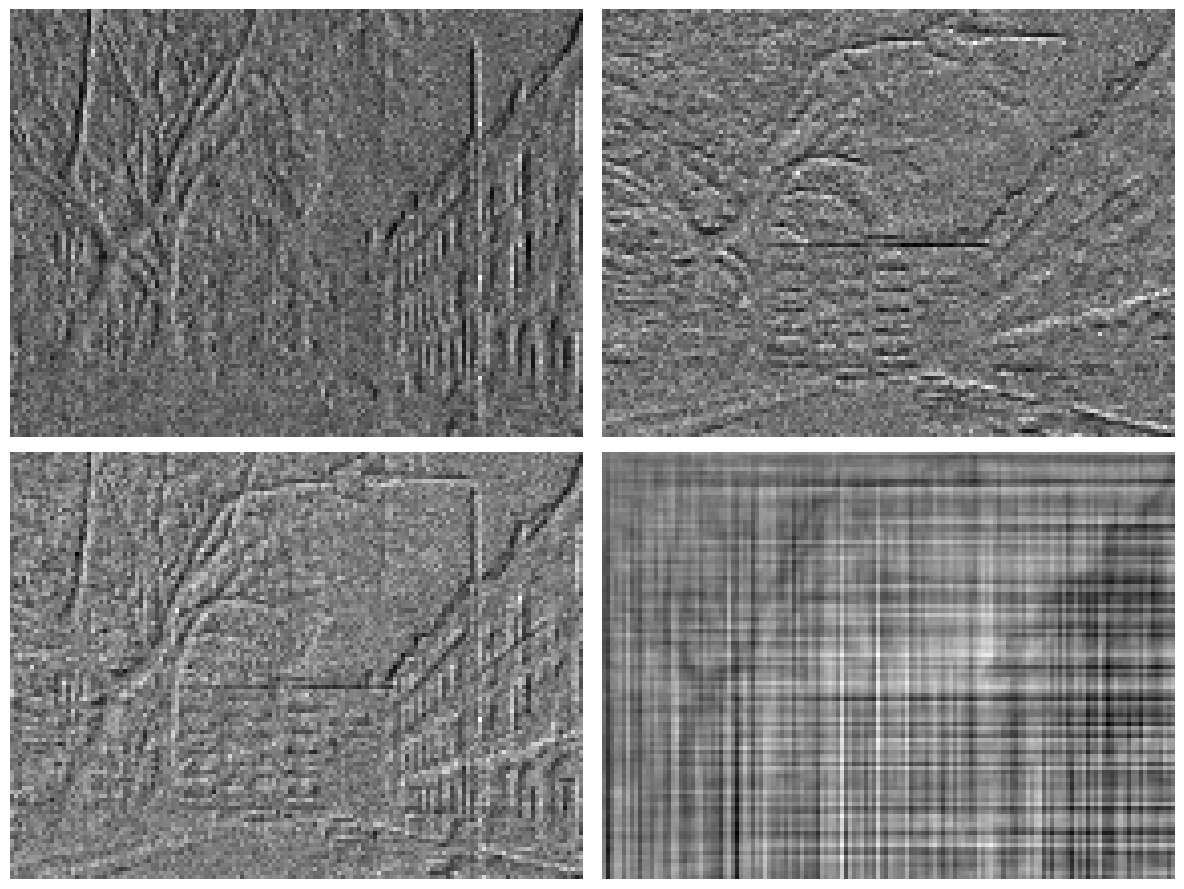

In [19]:
plt.figure(figsize=(12, 9))
plt.subplot(2, 2, 1)
# plt.title("Vertical Edge Detector Output")
plt.imshow(population_response_norm_vertical, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
# plt.title("Horizontal Edge Detector Output")
plt.imshow(population_response_norm_horizontal, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
# plt.title("Combined Edge Detector Output")
plt.imshow(combined_response, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
# plt.title("Reconstructed Image")
plt.imshow(decoded_population_response, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.savefig("figures/vert_hor_population_decoded.svg", transparent=True, bbox_inches='tight')

(np.float64(-0.5), np.float64(141.5), np.float64(105.5), np.float64(-0.5))

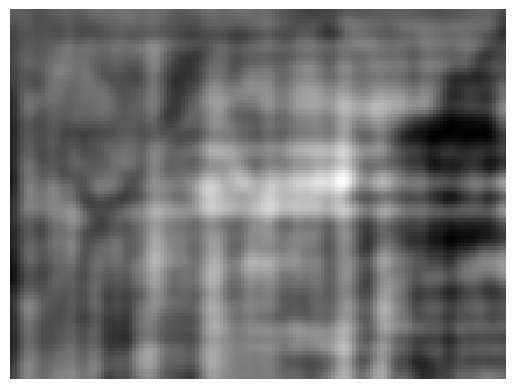

In [20]:
blurred_image = gaussian_filter(decoded_population_response, sigma=2)

plt.imshow(blurred_image, cmap='gray')
plt.axis('off')

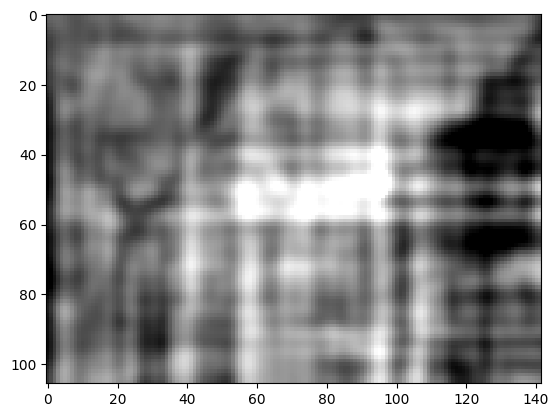

In [21]:
from skimage import exposure

# Contrast stretching
p2, p98 = np.percentile(blurred_image, (2, 98))
equalized_image = exposure.rescale_intensity(blurred_image, in_range=(p2, p98))

plt.imshow(equalized_image, cmap='gray')

## Analysis

Relative Entropy: 0.358042052523839


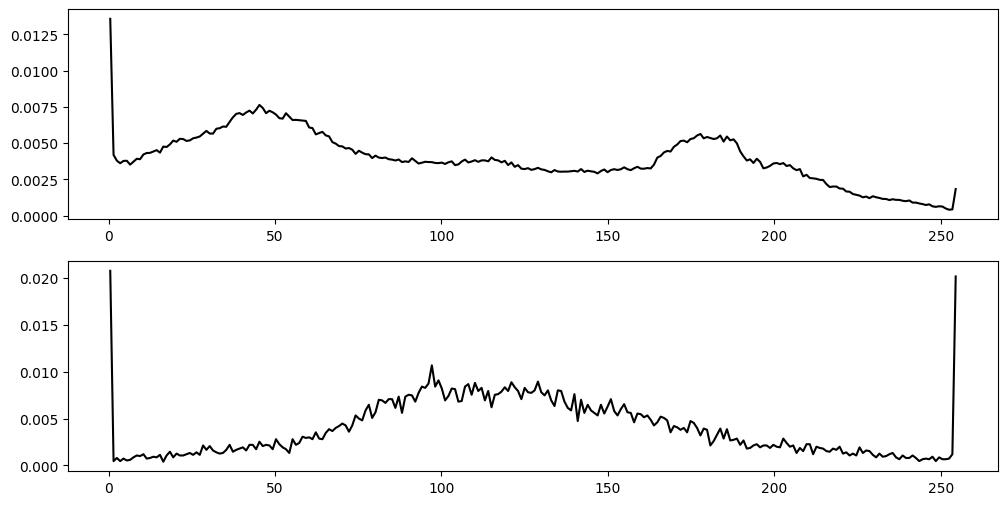

In [22]:
def normalize_to_255(image: np.ndarray) -> np.ndarray:
    # Ensure the image is a float for accurate normalization
    image = image.astype(np.float32)
    
    # Normalize to range 0-1
    image_min = image.min()
    image_max = image.max()
    if image_max - image_min == 0:
        return np.zeros_like(image, dtype=np.uint8)
    
    normalized = (image - image_min) / (image_max - image_min)
    
    # Scale to range 0-255 and convert to uint8
    normalized_255 = (normalized * 255).astype(np.uint8)
    
    return normalized_255

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
image_hist, image_bin_centers = line_hist(normalize_to_255(image_array), bins=256, ax=axes[0])
decoded_hist, decoded_bin_centers = line_hist(normalize_to_255(equalized_image), bins=256, ax=axes[1])
fig.savefig("figures/rel_entropy.svg", transparent=True, bbox_inches='tight')

rel_entropy = np.sum(rel_entr(image_hist, decoded_hist))  # rel_entr = P * log(P/Q)
print(f"Relative Entropy: {rel_entropy}")

Creating Gabor filters:   0%|          | 0/3 [00:00<?, ?it/s]

Orientation 16:   0%|          | 0/4 [00:00<?, ?it/s]

Orientation 32:   0%|          | 0/4 [00:00<?, ?it/s]

Orientation 64:   0%|          | 0/4 [00:00<?, ?it/s]

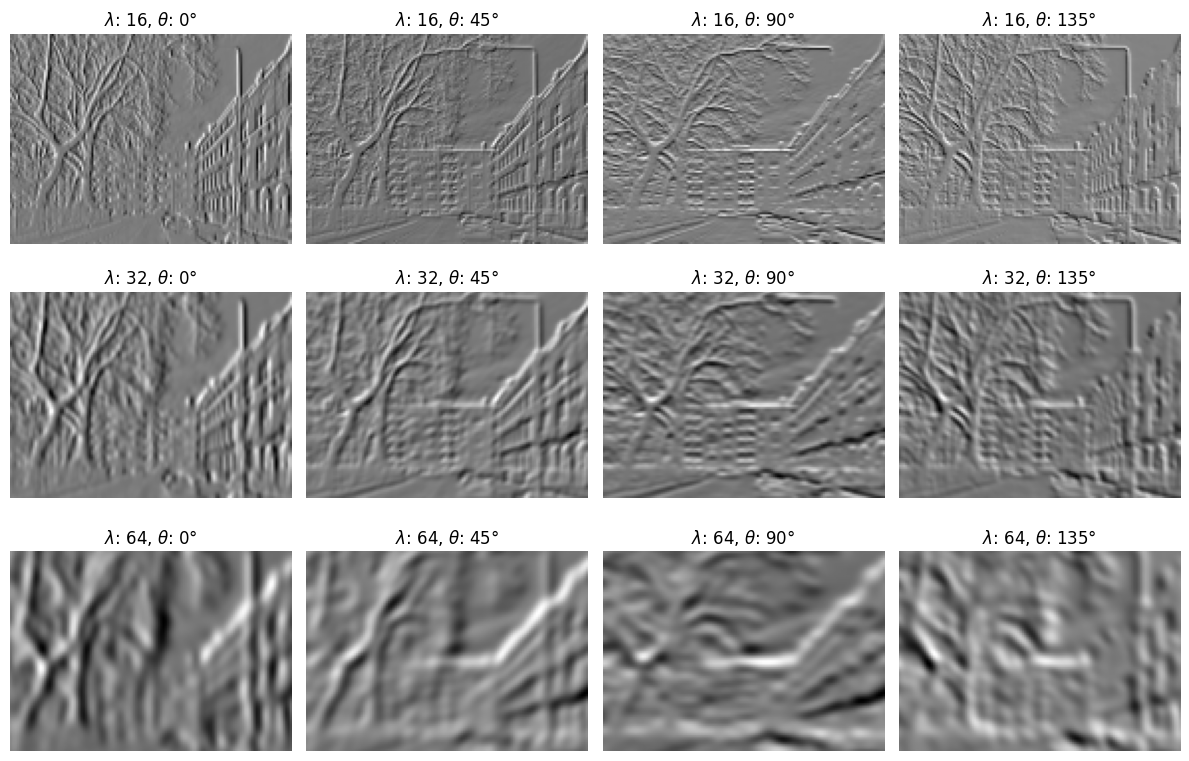

In [23]:
orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0°, 45°, 90°, 135°
wavelengths = [16, 32, 64]  # Example wavelengths for different scales
phase = np.pi/2

# Create and apply the filter bank
r_est_arrays = {}  # Dictionary to store responses for each (scale, orientation)
for wavelength in tqdm(wavelengths, desc="Creating Gabor filters"):
    # Define sigma values relative to wavelength (adjust as needed)
    sigma_x = wavelength / 5
    sigma_y = wavelength / 5
    for orientation in tqdm(orientations, desc=f"Orientation {wavelength}"):
        # Create the Gabor filter for this scale and orientation
        gabor = gabor_function(wavelength, orientation, phase, sigma_x, sigma_y)
        # Convolve the filter with the image (using 'same' mode to keep dimensions)
        # response = convolve2d(image_array, gabor_filter, mode='same', boundary='wrap')
        # r_est_array = encode(image_array, current_gabor, num_neurons=(wavelength, wavelength), ax=ax)
        r_est_array = encode(image_array, gabor, num_neurons=(image_array.shape[0] // 5, image_array.shape[1] // 5))
        
        r_est_arrays[(wavelength, orientation)] = r_est_array

fig, axs = plt.subplots(len(wavelengths), len(orientations), figsize=(12, 8))
for i, wavelength in enumerate(wavelengths):
    for j, orientation in enumerate(orientations):
        response = r_est_arrays[(wavelength, orientation)]
        axs[i, j].imshow(response, cmap='gray')
        axs[i, j].set_title(f"$\\lambda$: {wavelength}, $\\theta$: {np.degrees(orientation):.0f}°")
        axs[i, j].axis("off")
fig.tight_layout()
fig.savefig("figures/gabor_filter_bank.svg", transparent=True, bbox_inches='tight', dpi=1200)

Number of vertical neurons: 286, Number of horizontal neurons: 376


Generating spikes:   0%|          | 0/268 [00:00<?, ?it/s]

Generating spikes:   0%|          | 0/268 [00:00<?, ?it/s]

Relative Entropy: 0.21939155718556766
Number of vertical neurons: 114, Number of horizontal neurons: 150


Generating spikes:   0%|          | 0/106 [00:00<?, ?it/s]

Generating spikes:   0%|          | 0/106 [00:00<?, ?it/s]

Relative Entropy: 0.1995293803816054
Number of vertical neurons: 57, Number of horizontal neurons: 75


Generating spikes:   0%|          | 0/53 [00:00<?, ?it/s]

Generating spikes:   0%|          | 0/53 [00:00<?, ?it/s]

Relative Entropy: inf


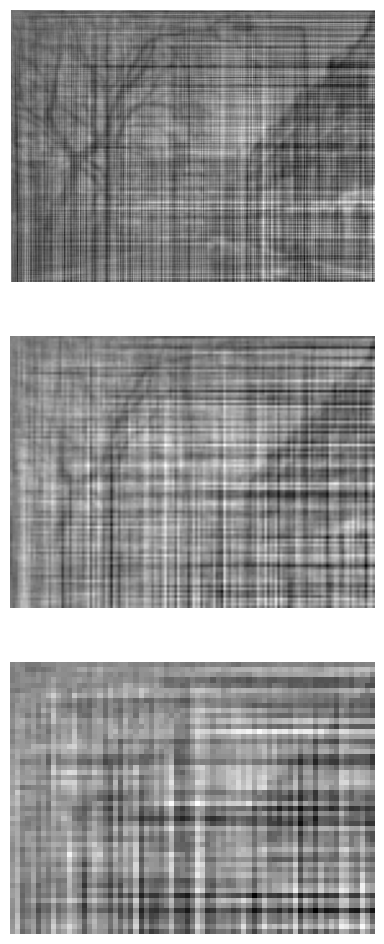

In [24]:
neuron_size = 32
wavelength = neuron_size / 2
phase = np.pi / 2
sigma_x = wavelength/4 # arbitrary choice
sigma_y = wavelength/4 # arbitrary choice
vertical_orientation = np.pi           # Vertical edge detector (sensitive to vertical edges)
horizontal_orientation = -np.pi / 2   # Horizontal edge detector (sensitive to horizontal edges)


# Create two Gabor filters with different orientations
gabor_vertical = gabor_function(wavelength, vertical_orientation, phase, sigma_x, sigma_y)
gabor_horizontal = gabor_function(wavelength, horizontal_orientation, phase, sigma_x, sigma_y)

# test multiple num_neurons
num_neurons_to_test = [(image_array.shape[0] // 2, image_array.shape[1] // 2),
                       (image_array.shape[0] // 5, image_array.shape[1] // 5),
                       (image_array.shape[0] // 10, image_array.shape[1] // 10)]

fig, axes = plt.subplots(len(num_neurons_to_test), 1, figsize=(12, 12))
for i, (n, m) in enumerate(num_neurons_to_test):
    print(f"Number of vertical neurons: {n}, Number of horizontal neurons: {m}")

    # Encoding
    r_est_array_vertical = encode(image_array, gabor_vertical, (n, m))
    r_est_array_horizontal = encode(image_array, gabor_horizontal, (n, m))

    # Generate spike trains
    population_spikes_vertical = model_response_spikes(r_est_array_vertical, T=1, abs_ref=0, rel_ref_mean=0, rng=rng)
    population_spikes_horizontal = model_response_spikes(r_est_array_horizontal, T=1, abs_ref=0, rel_ref_mean=0, rng=rng)

    # Compute population responses
    population_response_norm_vertical = compute_population_response(population_spikes_vertical, T=1)
    population_response_norm_horizontal = compute_population_response(population_spikes_horizontal, T=1)

    # Decoding
    decoded_population_response = decode_vh(population_response_norm_vertical, population_response_norm_horizontal)

    # Smooth decoded image
    blurred_image = gaussian_filter(decoded_population_response, sigma=3)
    
    p2, p98 = np.percentile(blurred_image, (2, 98))
    equalized_image = exposure.rescale_intensity(blurred_image, in_range=(p2, p98))

    axes[i].imshow(decoded_population_response, cmap='gray')
    axes[i].axis('off')
    
    image_hist, image_bin_centers = line_hist(normalize_to_255(image_array), bins=256)
    decoded_hist, decoded_bin_centers = line_hist(normalize_to_255(equalized_image), bins=256)

    rel_entropy = np.sum(rel_entr(image_hist, decoded_hist))  # rel_entr = P * log(P/Q)
    print(f"Relative Entropy: {rel_entropy}")
fig.savefig("figures/gabor_filter_bank_decoded.svg", transparent=True, bbox_inches='tight', dpi=1200)